Clincial plus postive regulation of apoptosis

In [2]:
# Importing the libraries
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

from sklearn.utils import resample
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import shap
from collections import defaultdict


In [3]:
#Added relative path, place path where data is in this line.
data = pd.read_csv("C:/Users/migue/OneDrive/Desktop/ML Project/Counts/Individual Files/Extracted/Invidual/Transposed_Postive_Regulation_Apoptosis.csv")
print(data)
#Need to work on this.
x_frame = data.iloc[: , :-1]
#x_frame = x_frame.to_numpy()

y_frame = data.iloc[:,-1:]


print(x_frame)
print(y_frame)

print(x_frame.shape)

print(y_frame.shape)

     Age at Index  Days from Birth  Gender  Year of Birth  \
0            46.0           -17037    male           1961   
1            63.0           -23211    male           1948   
2            56.0           -20555    male           1952   
3            65.0           -24050    male           1940   
4            60.0           -22029  female           1939   
..            ...              ...     ...            ...   
158          31.0           -11333    male           1969   
159          75.1           -27511  female           1933   
160          50.2           -18571    male           1958   
161          72.7           -26600  female           1925   
162          54.3           -20050    male           1951   

     Age of Diagnosis in Days  Days to Last Follow UP  Year of Diagnosis  \
0                       17037                     359               2007   
1                       23211                     139               2011   
2                       20555          

In [4]:
#Set varibles for data scaling and  stratified Kfold for the hw examples.
# Will need to do boostrapping not stratified kfold
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
le = preprocessing.LabelEncoder()
oe = OrdinalEncoder()
x_frame = oe.fit_transform(x_frame)
print(y_frame)
y_frame = le.fit_transform(y_frame)
print(y_frame)
#(categories = ['Age at Index','Age of Diagnosis in Days','Days from Birth','Days to Last Follow UP','Gender','Sample Type','Treament Or Therapy','Treatment Type','Vital Status'])
cv_outer = StratifiedKFold(n_splits=6, shuffle=True, random_state=1)
cv_inner = StratifiedKFold(n_splits=6, shuffle=True, random_state=2)


    Vital Status
0           Dead
1          Alive
2           Dead
3           Dead
4           Dead
..           ...
158         Dead
159         Dead
160         Dead
161         Dead
162         Dead

[163 rows x 1 columns]
[1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0
 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


In [5]:
#Uses CV inner to determine best parameters for xgb using the RandomizedSearchCV parameter optimization. 
model_xgb = xgb.XGBClassifier(random_state=1,objective='multi:softmax',eval_metric='logloss',use_label_encoder=False,num_class =8)
xgb_pipeline = Pipeline([
    ('pca', PCA()), 
    ('model_xgb', model_xgb,)
])

xgb_param= {
    'pca__n_components': [0.60,0.70,0.80,0.90],
    'model_xgb__max_depth': [2, 3, 5,7,9],
    'model_xgb__n_estimators': [10, 100, 500],
    'model_xgb__average':['none','micro','macro','weighted']}
xgb_random = RandomizedSearchCV(xgb_pipeline, xgb_param, cv=cv_inner, scoring='accuracy')
print(xgb_random)
print()

RandomizedSearchCV(cv=StratifiedKFold(n_splits=6, random_state=2, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('model_xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                     

In [6]:
#Code below is an example for the hw assignment for how to perform nested k fold on the stratified k fold splits previously.
#Sets variables for the following for loop in the code below. 
import warnings 
#Silences warnings. 
warnings.filterwarnings('ignore')

rf_outer_results = list()
rf_best_f1_score=float('-inf')
rf_best_parameters={}

xgb_outer_results = list()
xgb_best_f1_score= float('-inf')
xgb_best_parameters={}

#for loop that runs 1 times that uses the optimized parameters from above to train the models using a new outer split of the data. 
iter_num=1
for train_ix, test_ix in cv_outer.split(x_frame,y_frame):
    print('Iteration',iter_num)
    iter_num +=1
    # split data
    X_train, X_test, y_train, y_test = train_test_split(x_frame[train_ix, :], y_frame[train_ix], train_size =0.8,test_size =0.2, random_state = 1)
    #X_train, X_test = x_frame[train_ix, :], x_frame[test_ix, :]
    #y_train, y_test = y_frame[train_ix], y_frame[test_ix]

    #XGBoost
    result = xgb_random.fit(X_train, y_train)
    best_model = result.best_estimator_
    yhat = best_model.predict(X_test)
    f1score=f1_score(y_test,yhat, average = 'weighted')
    if f1score >= xgb_best_f1_score:       
        xgb_best_f1_score=f1score
        xgb_best_parameters=result.best_params_
    xgb_outer_results.append(f1score)
    print('XGB inner test: est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
    print()

# summarize the estimated performance of the model

xgb_mean=np.mean(xgb_outer_results)

print('XGB outer test: f1-score mean: %.3f (std: %.3f)' % (xgb_mean, np.std(xgb_outer_results)))
    

Iteration 1
[11:07:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:07:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:07:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This c

[11:08:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:08:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:08:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:08:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:08:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:08:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:08:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:08:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:08:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:08:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:08:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:08:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:08:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

XGB inner test: est=0.824, cfg={'pca__n_components': 0.9, 'model_xgb__n_estimators': 100, 'model_xgb__max_depth': 9, 'model_xgb__average': 'macro'}

Iteration 3
[11:09:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:

[11:09:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:09:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

XGB inner test: est=0.833, cfg={'pca__n_components': 0.8, 'model_xgb__n_estimators': 500, 'model_xgb__max_depth': 7, 'model_xgb__average': 'none'}

Iteration 4
[11:09:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:3

[11:09:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:09:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

XGB inner test: est=0.833, cfg={'pca__n_components': 0.8, 'model_xgb__n_estimators': 10, 'model_xgb__max_depth': 3, 'model_xgb__average': 'macro'}

Iteration 5
[11:09:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:09:5

[11:10:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:10:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:10:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:10:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:10:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:10:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:10:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:10:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:10:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:10:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:10:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:10:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

[11:10:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:10:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:10:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa


XGB inner test: est=0.815, cfg={'pca__n_components': 0.9, 'model_xgb__n_estimators': 500, 'model_xgb__max_depth': 3, 'model_xgb__average': 'macro'}

XGB outer test: f1-score mean: 0.737 (std: 0.065)


In [7]:
#Find the highest mean between the trained models, it then returns the best performing model based on that. 
defaulttParm=model_xgb.get_xgb_params()
pca=PCA(xgb_best_parameters['pca__n_components'])
for k in xgb_best_parameters.keys():
    if 'model_xgb' in k:
        parm=k.split('__')[1]
        defaulttParm[parm]=xgb_best_parameters[k]
defaulttParm['use_label_encoder']=True
myFinalModel=xgb.XGBClassifier(**defaulttParm)

In [8]:
#PCA
x_pca=pca.fit_transform(x_frame)

In [9]:
print(cross_val_score(myFinalModel,x_pca, y_frame,cv=9))

[11:10:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:10:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:11:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

In [10]:
print(cross_val_score(myFinalModel,x_frame, y_frame,cv=9))

[11:11:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:11:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:11:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a fa

In [11]:
# Determines the f-score of the model using a new tenth split. 
X_train, X_test, y_train, y_test = train_test_split(x_frame, y_frame, test_size=0.1, random_state=1)
myFinalModel.fit(X_train,y_train)
yhat=myFinalModel.predict(X_test)
f1score=f1_score(yhat,y_test, average ='weighted')
print(f1score)

[11:11:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.838133874239351


In [12]:
#Perform Shap analysis on the predictiors of the data for the class = 0, as it the model balances itself to the final prediction.
#Each predictor either increase (red) or decreases(blue) the prediction score. 
shap.initjs()
explainer = shap.KernelExplainer(myFinalModel.predict,X_train)

shap_values = explainer.shap_values(X_test[0:,])

shap.force_plot(explainer.expected_value, shap_values[0])

Using 146 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/17 [00:00<?, ?it/s]

In [13]:
#Perform Shap analysis on the predictiors of the data for the class = 0, as it the model balances itself to the final prediction.
#Each predictor either increase (red) or decreases(blue) the prediction score. 
shap.initjs()
explainer = shap.KernelExplainer(myFinalModel.predict,X_train)
shap_values = explainer.shap_values(X_test[0:,])
shap.force_plot(explainer.expected_value, shap_values[2], X_test[0,:])

Using 146 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/17 [00:00<?, ?it/s]

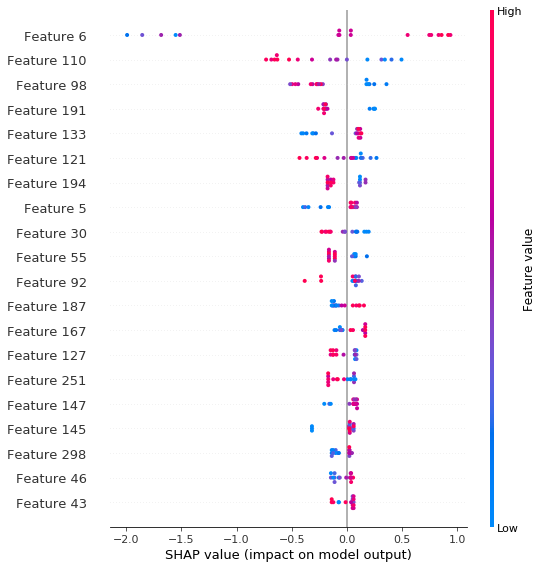

In [14]:
#This code produces a beeswarm plot showing the impact of the top 10 features on the model when its value is 0.
#creates the explainer object
explainer = shap.TreeExplainer(myFinalModel)
#produces values from the test set. 
shap_values = explainer.shap_values(X_test)
#creates the shap object for the plot
shap_object = explainer(X_test)
#produces the plot
shap.summary_plot(shap_values[0],X_test)

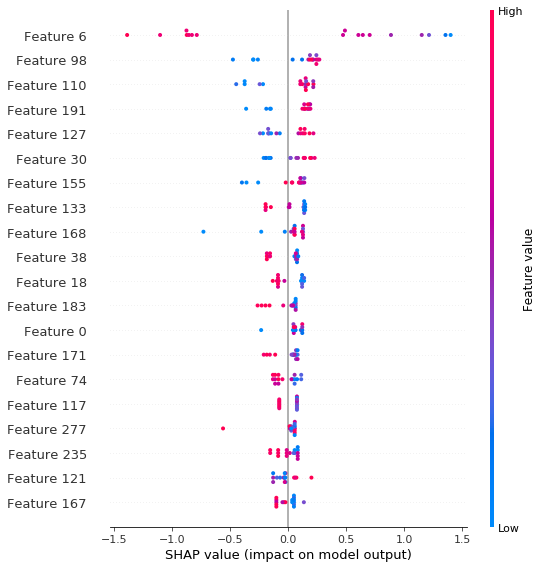

In [15]:
#This code produces a beeswarm plot showing the impact of the top 10 features on the model when its value is 1.
#creates the explainer object
explainer = shap.TreeExplainer(myFinalModel)
#produces values from the test set. 
shap_values = explainer.shap_values(X_test)
#creates the shap object for the plot
shap_object = explainer(X_test)
#produces the plot
shap.summary_plot(shap_values[1],X_test)

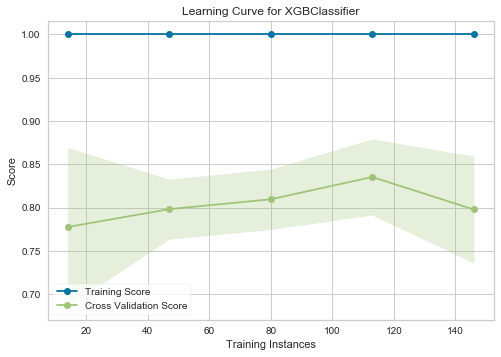

LearningCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000214A9D5FD48>,
              cv=10,
              estimator=XGBClassifier(average='macro', base_score=0.5,
                                      booster='gbtree', colsample_bylevel=1,
                                      colsample_bynode=1, colsample_bytree=1,
                                      enable_categorical=False,
                                      eval_metric='logloss', gamma=0, gpu_id=-1,
                                      importance_type=None,
                                      interaction_constraints='',
                                      learning_rate=0.30...
                                      n_estimators=500, n_jobs=16, num_class=8,
                                      num_parallel_tree=1,
                                      objective='multi:softmax',
                                      predictor='auto', random_state=1,
                                      reg_alpha=0, reg_lamb

In [28]:
#Uses the learning curve function from the yellowbrick library to identify if the model could benefit from more training samples. 

from yellowbrick.model_selection import learning_curve
#prints the learning curve plot.
print(learning_curve(myFinalModel,x_frame, y_frame,cv=10,))

[14:09:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


>1, train: 0.965, test: 0.949
[14:10:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


>2, train: 0.965, test: 0.949
[14:11:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parame

>19, train: 0.965, test: 0.949
[14:22:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "average" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


>20, train: 0.965, test: 0.949


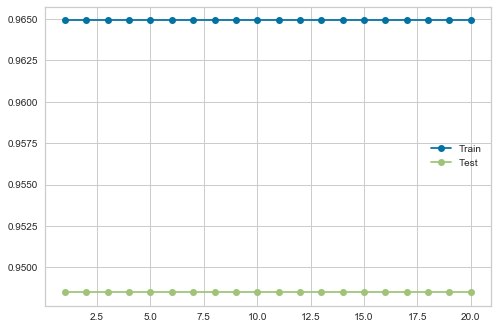

In [27]:
#import libraries 
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
# create dataset with n_samples. 
X, y = make_classification(n_samples=100000, random_state=1)
# split into train test sets 80 20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# define lists to collect accuracy scores. 
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
#for loop that takes split above and plots train vs test to determine fit.
for i in values:
    myFinalModel.fit(X_train, y_train)
    # evaluate on the train dataset
    train_yhat = myFinalModel.predict(X_train)
    #determines accuracy score of training data set model.
    train_acc = accuracy_score(y_train, train_yhat)
    #appends train accuracy score to list. 
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_yhat = myFinalModel.predict(X_test)
    #determines accuracy score of test data set model 
    test_acc = accuracy_score(y_test, test_yhat)
    #appends the test accuracy score to list. 
    test_scores.append(test_acc)
    # summarize progress
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores 
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

Based on the plots above the model is underfitting and would benefit from more trainin data. 

No exploratory data analysis was performed as entries with missing data were removed, the data was already normalized and removing outliers would not be ideal as the normal varience in the population is uknown for all 62000 transcripts. 